<a href="https://colab.research.google.com/github/RohanBolle/BigCrunch/blob/main/Copy_of_Big_Crunch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

ΣΩ_i = 5.000   →   Ω_k = -4.000
ΣΩ_i = 1.000   →   Ω_k = -0.000
ΣΩ_i = 1.000   →   Ω_k = -0.000
Turn-around at a_max = 38.118
Lifetime of the universe:  t_crunch = 34772988254229860352.000  (in 1/H0 units)


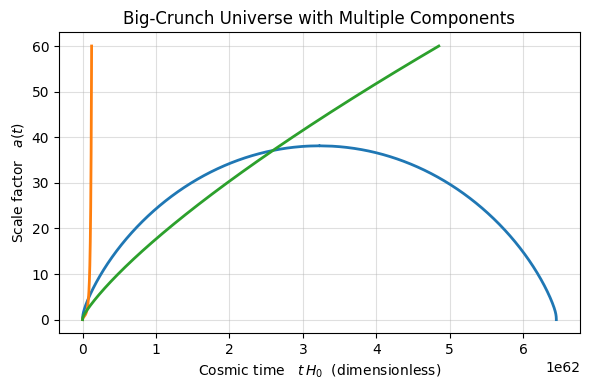

In [20]:
"""
Multi-component Friedmann solver that produces a Big Crunch

Conventions
-----------
c = 1,  a0 = 1  (present-day scale factor)
Time is reported in units of 1/H0  (e.g. 1/H0 ≈ 14 Gyr for H0 = 70 km/s/Mpc)

Components implemented
----------------------
Radiation        :  w = 1/3   (ρ ∝ a⁻⁴)
Matter           :  w = 0     (ρ ∝ a⁻³)
Cosmic strings   :  w = –1/3  (ρ ∝ a⁻²)
Domain walls     :  w = –2/3  (ρ ∝ a⁻¹)
Stiff matter     :  w = 1     (ρ ∝ a⁻⁶)
Dark energy (Λ)  :  w = –1    (ρ ∝ const.; ΩΛ may be *negative*)
Spatial curvature:  encoded through Ω_k = 1 – ΣΩ_i   (positive k ⇒ Ω_k < 0)

A closed (Ω_k < 0) matter-dominated model *or* a model with negative Λ will
recollapse.  By default we combine both so the turnaround happens quickly
enough to see on a small time axis.
"""
import numpy as np
from scipy.integrate import quad
import matplotlib.pyplot as plt
from math import log as ln


# -------------------------------------------------------------------------
# 0. Helper: Defining G_Star functions for a**B, 1+l*ln(a)
# -------------------------------------------------------------------------

def G(a,f,n):
  if f==0:
    if n==0:
      func = a*(1 - ln(a))
    elif n==1:
      func = a**2*(1 - 2*ln(a))
    elif n==2:
      func = 3*a**2

  elif f==1:
    if n==0:
      func = ln(a) + 2
    elif n==1:
      func = ln(a)**2 + 3*ln(a) + 5/2
    elif n==2:
      func = ln(a)**2 + 8*ln(a)/3 + 17/9

  return func

# -----------------------------------------------------------------------------
# 1. Specify the energy-density parameters Ω_i at a = 1
#    ***Adjust these to taste, but keep  ΣΩ_i  > 1  OR  choose ΩΛ < 0
# -----------------------------------------------------------------------------
params ={
    "bigCrunch":{
    "radiation"      : 1.0e-4,   # Ω_r [0.10]
    "matter"         : 5.00,   # Ω_m [1.20]
    "cosmic_strings" : 0.00,   # Ω_cs[0.05]
    "domain_walls"   : 0.00,   # Ω_dw[0.05]
    "stiff_matter"   : 0.00,   # Ω_sm[0.0]
    "dark_energy"    : 0.00   # Ω_Λ [-0.50](NEGATIVE ⇒ acts like an attractive force)
    },
    "senario1":{
    "radiation"      : 1.0e-4,   # Ω_r
    "matter"         : 0.30,     # Ω_m
    "cosmic_strings" : 0.00,     # Ω_cs
    "domain_walls"   : 0.00,     # Ω_dw
    "stiff_matter"   : 0.00,     # Ω_sm
    "dark_energy"    : 0.70      # Ω_Λ
    },
    "senario2":{
    "radiation"      : 1.0e-4,   # Ω_r
    "matter"         : 1.00,     # Ω_m
    "cosmic_strings" : 0.00,     # Ω_cs
    "domain_walls"   : 0.00,     # Ω_dw
    "stiff_matter"   : 0.00,     # Ω_sm
    "dark_energy"    : 0.00      # Ω_Λ
    }
}

# Barotropic indices  w  for the components
w_map = {
    "radiation"      : 1/3,
    "matter"         : 0.0,
    "cosmic_strings" : -1/3,
    "domain_walls"   : -2/3,
    "stiff_matter"   : 1.0,
    "dark_energy"    : -1.0
}

# Present-day curvature parameter Ω_k
Omega_total = sum(params["bigCrunch"].values())
Omega_k = 1.0 - Omega_total        # closed if Ω_k < 0
print(f"ΣΩ_i = {Omega_total:.3f}   →   Ω_k = {Omega_k:.3f}")

Omega_total0 = sum(params["senario1"].values())
Omega_k0 = 1.0 - Omega_total0       # closed if Ω_k < 0
print(f"ΣΩ_i = {Omega_total0:.3f}   →   Ω_k = {Omega_k0:.3f}")

Omega_total1 = sum(params["senario2"].values())
Omega_k1 = 1.0 - Omega_total1       # closed if Ω_k < 0
print(f"ΣΩ_i = {Omega_total1:.3f}   →   Ω_k = {Omega_k1:.3f}")
# -------------------------------------------------------------------------
# 2. Helper: E(a) = H(a) / H0  (dimensionless Hubble parameter)
# -------------------------------------------------------------------------
def E2(a,n,s: float) -> float:
    """Dimensionless Hubble parameter squared, E(a)^2."""
    G0=1
    f=1
    if n==0:
      term_sum = Omega_k * a**-2                     # curvature
      for name, Ω in params[s].items():
          w = w_map[name]
          term_sum += Ω*G(a,f,0) * a**(-3 * (1 + w)) + Ω**2 *G(a,f,1) * a**(-6 * (1 + w)) + Ω *G(a,f,2) * a**(-3 * (1 + w))
      return term_sum
    elif n==1:
      term_sum = Omega_k0 * a**-2                     # curvature
      for name, Ω in params[s].items():
          w = w_map[name]
          term_sum += Ω*G(a,f,0) * a**(-3 * (1 + w)) + Ω**2 *G(a,f,1) * a**(-6 * (1 + w)) + Ω *G(a,f,2) * a**(-3 * (1 + w))
      return term_sum
    elif n==2:
      term_sum = Omega_k1 * a**-2                     # curvature
      for name, Ω in params[s].items():
          w = w_map[name]
          term_sum += Ω*G(a,f,0) * a**(-3 * (1 + w)) + Ω**2 *G(a,f,1) * a**(-6 * (1 + w)) + Ω *G(a,f,2) * a**(-3 * (1 + w))
      return term_sum

# def E2(a,n,s: float) -> float:
#     """Dimensionless Hubble parameter squared, E(a)^2."""
#     if n==0:
#       term_sum = Omega_k * a**-2                     # curvature
#       for name, Ω in params[s].items():
#           w = w_map[name]
#           term_sum += Ω * a**(-3 * (1 + w))
#       return term_sum
#     elif n==1:
#       term_sum = Omega_k0 * a**-2                     # curvature
#       for name, Ω in params[s].items():
#           w = w_map[name]
#           term_sum += Ω * a**(-3 * (1 + w))
#       return term_sum
#     elif n==2:
#       term_sum = Omega_k1 * a**-2                     # curvature
#       for name, Ω in params[s].items():
#           w = w_map[name]
#           term_sum += Ω * a**(-3 * (1 + w))
#       return term_sum

# -------------------------------------------------------------------------
# 3. Find the turnaround point  a_max  where  E^2 = 0  (expansion stops)
# -------------------------------------------------------------------------
from mpmath import findroot
a_max = float(findroot(lambda x: E2(x,0,'bigCrunch'), 1.0))      # initial guess 2 ≳ 1
print(f"Turn-around at a_max = {a_max:.3f}")

# -------------------------------------------------------------------------
# 4. Cosmic time t(a) by quadrature  t = ∫ da / [a H0 E(a)]
# -------------------------------------------------------------------------
H0 = 2.27e-18   # we work in units where H0 = 1; multiply by 1/H0 later if needed

def dt_da(a,n,s):           # integrand  dt/da  for outward (+) branch
    return 1.0 / (H0* a * np.sqrt(E2(a,n,s)))

# Time from today (a=1) to the turnaround
t_half, _ = quad(lambda a: dt_da(a,0,'bigCrunch'), 0.01, a_max, epsabs=1e-9, epsrel=1e-9, limit=200)
t_total = 2.0 * t_half
print(f"Lifetime of the universe:  t_crunch = {t_total:.3f}  (in 1/H0 units)")

# -------------------------------------------------------------------------
# 5. Generate a(t) for plotting: integrate out, then mirror back
# -------------------------------------------------------------------------
a_grid = np.linspace(0.01, a_max, 1000)
t_grid = np.array([quad(lambda x: dt_da(x,0,'bigCrunch'), 0.0, a)[0] for a in a_grid])

a_grid1 = np.linspace(0.01, 60.0, 1000)
t_grid1 = np.array([quad(lambda x: dt_da(x,1,'senario1'), 0.0, a)[0] for a in a_grid1])

a_grid2 = np.linspace(0.01, 60.0, 1000)
t_grid2 = np.array([quad(lambda x: dt_da(x,2,'senario2'), 0.0, a)[0] for a in a_grid1])
# Contracting branch: reverse arrays and shift time by t_half
a_full = np.concatenate([a_grid, a_grid[::-1]])
t_full = np.concatenate([t_grid,  t_half + (t_half - t_grid[::-1])])

# -------------------------------------------------------------------------
# 6. Plot
# -------------------------------------------------------------------------
plt.figure(figsize=(6, 4))
plt.plot(t_full /(5.390559999e-44), a_full, lw=2)

plt.plot(t_grid1/ (5.390559999e-44) , a_grid1, lw=2)
plt.plot(t_grid2/ (5.390559999e-44) , a_grid2, lw=2)
plt.xlabel(r"Cosmic time   $t\,H_0$  (dimensionless)")
plt.ylabel(r"Scale factor   $a(t)$")
plt.title("Big-Crunch Universe with Multiple Components")
plt.grid(True, alpha=0.4)
plt.tight_layout()
plt.show()